In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm
import missingno as msno
import seaborn as sns
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import UnivariateSpline
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import warnings
warnings.simplefilter('ignore') # 
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
multi_performance = pd.read_csv('FNMA_MF_Loan_Performance_Data_202406.csv')
dscr = pd.read_csv('FNMA_MF_LOAN_Current DSCR_062024.csv')

In [3]:
multi_performance

,Loan Number,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,Interest Type,Loan Product Type,Original UPB,Amortization Term,Original Interest Rate,Lien Position,Transaction ID,Issue Date,Loan Acquisition LTV,Underwritten DSCR,Underwritten DSCR Type,Original Term,Original I/O Term,I/O End Date,Loan Ever 60+ Days Delinquent,Loss Sharing Type,Modified Loss Sharing Percentage,Number of Properties at Acquisition,Property Acquisition Total Unit Count,Specific Property Type,Year Built,Property City,Property State,Property Zip Code,Metropolitan Statistical Area,Physical Occupancy %,Liquidation/Prepayment Code,Liquidation/Prepayment Date,Foreclosure Date,Credit Event Date,Foreclosure Value,Lifetime Net Credit Loss Amount,Sale Price,Default Amount,Credit Event Type,Reporting Period Date,Loan Active Property Count,Note Rate,Maturity Date - Current,UPB - Current,Delinquency UPB,Loan Payment Status,SDQ Indicator,Most Recent Modification Date,Modification Indicator,Defeasance Date,Prepayment Provision,Prepayment Provision End Date,Affordable Housing Type,MCIRT Deal ID,MCAS Deal ID,DUS Prepayment Outcomes,DUS Prepayment Segments,Loan Age,Green Bond Indicator,Social Bond Indicator
0,140296,2000-10-31,1985-07-16,2001-08-10,"$82,501.71",NaN,ARM,DUS,"$82,501.71",NaN,5.1960,First,NaN,NaN,50.0000,NaN,NaN,360,NaN,NaN,Y,NaN,NaN,1.0000,4.0000,Multifamily,NaN,SAN DIEGO,CA,92102,"SAN DIEGO-CHULA VISTA-CARLSBAD, CA METROPOLITA...",0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-01,1.0000,NaN,2001-08-10,"$82,501.71",NaN,Current,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,140296,2000-10-31,1985-07-16,2001-08-10,"$82,501.71",NaN,ARM,DUS,"$82,501.71",NaN,5.1960,First,NaN,NaN,50.0000,NaN,NaN,360,NaN,NaN,Y,NaN,NaN,1.0000,4.0000,Multifamily,NaN,SAN DIEGO,CA,92102,"SAN DIEGO-CHULA VISTA-CARLSBAD, CA METROPOLITA...",0.0000,"Fully Paid, Prepaid",2000-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-01-01,1.0000,5.6100,2001-08-10,"$82,501.71",NaN,90+ Days Delinquent,Y,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,140296,2000-10-31,1985-07-16,2001-08-10,"$82,501.71",NaN,ARM,DUS,"$82,501.71",NaN,5.1960,First,NaN,NaN,50.0000,NaN,NaN,360,NaN,NaN,Y,NaN,NaN,1.0000,4.0000,Multifamily,NaN,SAN DIEGO,CA,92102,"SAN DIEGO-CHULA VISTA-CARLSBAD, CA METROPOLITA...",0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-12-01,1.0000,NaN,2001-08-10,"$82,501.71",NaN,Current,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,140296,2000-10-31,1985-07-16,2001-08-10,"$82,501.71",NaN,ARM,DUS,"$82,501.71",NaN,5.1960,First,NaN,NaN,50.0000,NaN,NaN,360,NaN,NaN,Y,NaN,NaN,1.0000,4.0000,Multifamily,NaN,SAN DIEGO,CA,92102,"SAN DIEGO-CHULA VISTA-CARLSBAD, CA METROPOLITA...",0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-10-01,1.0000,NaN,2001-08-10,"$82,501.71",NaN,Current,N,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140297,2000-10-31,1985-07-18,2001-08-10,"$548,872.98",NaN,ARM,DUS,"$548,872.98",NaN,5.1960,First,NaN,NaN,50.0000,NaN,NaN,360,NaN,NaN,Y,NaN,NaN,1.0000,2.0000,Multifamily,NaN,SAN DIEGO,CA,92116,"SAN DIEGO-CHULA VISTA-CARLSBAD, CA METROPOLITA...",0.0000,"Fully Paid, Prepaid",2000-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-01-01,1.0000,5.5500,2000-08-10,"$205,587.07",NaN,90+ Days Delinquent,Y,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4793120,8300008176,2021-02-25,2021-02-25,2051-02-01,"$16,400,000.00",Interest Only/Amortizing/Balloon,Fixed,Non-DUS,"$16,400,000.00",480.0000,4.1300,First,NaN,NaN,62.4000,1.1800,UW DSCR NCF,360,24.0000,2023-02-01,N,Pari Passu,NaN,1.0000,102.0000,Multifamily,1925,NEW YORK,NY,10027,"NEW YORK-NEWARK-JERSEY CITY, NY-NJ-PA METROPOL...",95.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-09-01,1.0000,4.1300,2051-02-01,"$16,400,000.00",NaN,Current,N,NaN,N

In [4]:
total_num_loans = multi_performance['Loan Number'].nunique()
print(f'Total Number of Multi-Loans in the dataset: {total_num_loans}')

Total Number of Multi-Loans in the dataset: 67563


## 1. Data Processing

In [5]:
# ---------------------------------
# Date and Time Processing
# ---------------------------------
# Convert date columns to datetime
multi_performance['Reporting Period Date'] = pd.to_datetime(multi_performance['Reporting Period Date'])
multi_performance['Note Date'] = pd.to_datetime(multi_performance['Note Date'])
multi_performance['Acquisition Date'] = pd.to_datetime(multi_performance['Acquisition Date'])
multi_performance['Maturity Date at Acquisition'] = pd.to_datetime(multi_performance['Maturity Date at Acquisition'])
multi_performance['Maturity Date - Current'] = pd.to_datetime(multi_performance['Maturity Date - Current'])

# Extract time-related features
multi_performance['Year'] = multi_performance['Reporting Period Date'].dt.year
multi_performance['Note Quarter'] = multi_performance['Note Date'].dt.to_period('Q')
multi_performance['Note Year'] = multi_performance['Acquisition Date'].dt.year
multi_performance['Original Term Year'] = (multi_performance['Original Term'] / 12).round(0)
multi_performance['Amortization Year'] = (multi_performance['Amortization Term'] / 12).round(0)

# ---------------------------------
# Data Sorting and Filtering
# ---------------------------------
# Sort the DataFrame by Loan Number and Reporting Period Date
multi_performance = multi_performance.sort_values(by=['Loan Number', 'Reporting Period Date'])

# Filter for Note Quarter after 1999Q4
multi_performance = multi_performance[multi_performance['Note Quarter'] > pd.Period('1999Q4', freq='Q-DEC')]

# ---------------------------------
# Data Cleaning
# ---------------------------------
# Remove dollar signs and convert columns to float
multi_performance['Original UPB'] = (
    multi_performance['Original UPB'].replace('[\$,]', '', regex=True).astype(float)
)
multi_performance['UPB - Current'] = (
    multi_performance['UPB - Current'].replace('[\$,]', '', regex=True).astype(float)
)

# ---------------------------------
# Percentage Adjustments
# ---------------------------------
# Convert percentages to decimals
multi_performance['Loan Acquisition LTV'] /= 100
multi_performance['Original Interest Rate'] /= 100

# ---------------------------------
# Property Metrics
# ---------------------------------
# Calculate building-related metrics
multi_performance['Year Built'] = pd.to_numeric(multi_performance['Year Built'], errors='coerce')
multi_performance['Building Age'] = multi_performance['Note Year'] - multi_performance['Year Built']

# Calculate home value metrics
multi_performance['Underwritten Home Value'] = (
    multi_performance['Original UPB'] / multi_performance['Loan Acquisition LTV']
)
multi_performance['Underwritten Home Value'].replace([np.inf, -np.inf], np.nan, inplace=True)
multi_performance['Underwritten Home Value Per Unit'] = (
    multi_performance['Underwritten Home Value'] / multi_performance['Property Acquisition Total Unit Count']
)

# Calculate log of unit count
multi_performance['log_Num_Unit'] = np.log(multi_performance['Property Acquisition Total Unit Count'])

# ---------------------------------
# Financial Metrics
# ---------------------------------
# Calculate monthly rate and interest payment
multi_performance['monthly_rate'] = multi_performance['Original Interest Rate'] / 12
multi_performance['Interest Payment'] = (
    multi_performance['monthly_rate'] * multi_performance['UPB - Current']
)

# ---------------------------------
# GDP Deflator Adjustment
# ---------------------------------
# Load GDP deflator data
GDPDEF = pd.read_csv('GDPDEF_Annual.csv')

# Calculate deflator base and merge with main DataFrame
GDPDEF['2023_def_base'] = 121.261 / GDPDEF['GDPDEF']
GDPDEF['Note Year'] = GDPDEF['Year']
multi_performance = multi_performance.merge(
    GDPDEF[['Note Year', '2023_def_base']], on='Note Year', how='left'
)

# Adjust home value by deflator
multi_performance['Real Underwritten Home Value Per Unit'] = (
    multi_performance['Underwritten Home Value Per Unit'] * multi_performance['2023_def_base']
)
multi_performance['Log Real Underwritten Home Value Per Unit'] = np.log(
    multi_performance['Real Underwritten Home Value Per Unit']
)

## 2. Computing Annual Debt Service

In [6]:
def calculate_loan_metrics(loan_df):
    import pandas as pd
    import numpy as np
    # Define the payment computation with logic for different amortization types
    monthly_rate = loan_df['monthly_rate'].iloc[0]
    upb_0  = loan_df['Original UPB'].iloc[0] 
    AT = loan_df['Amortization Term'].iloc[0]
    
    normal_amort_types = ['Amortizing Balloon', 'Fully Amortizing']
    io_amort_types = ['Interest Only/Balloon', 'Interest Only/Amortizing/Balloon', 'Interest Only/Fully Amortizing']
    
    amort_type = loan_df['Amortization Type'].iloc[0]
    
    loan_df['Computed PMT'] = upb_0*(monthly_rate*(1+monthly_rate)**AT)/((1+monthly_rate)**AT -1)
        
    if amort_type in io_amort_types:
        io_end_date = pd.to_datetime(loan_df['I/O End Date'].iloc[0]) if not pd.isna(loan_df['I/O End Date'].iloc[0]) else None
        if io_end_date is not None:
            mask = loan_df['Reporting Period Date'] < io_end_date
            loan_df.loc[mask, 'Computed PMT'] = loan_df.loc[mask, 'Interest Payment']

    
    # Calculate principal paid
    loan_df['Computed Paid_Principal'] = loan_df['Computed PMT'] - loan_df['Interest Payment']
    
    # Update UPB
    loan_df['Computed UPB current'] = loan_df['Original UPB'] - loan_df['Computed Paid_Principal'].cumsum().shift(1, fill_value=loan_df['Original UPB'].iloc[0])
    
    # UPB_0
    loan_df['Computed UPB current'].iloc[0] = upb_0
    # Compute actual paid principal
    loan_df['Actual Paid_Principal'] = loan_df['UPB - Current'] - loan_df['UPB - Current'].shift(-1)
    
    # Compute actual PMT
    loan_df['Actual PMT'] = loan_df['Actual Paid_Principal'] + loan_df['Interest Payment']
    
    # Compute actual amortization term, using logarithmic formula with safeguard against division by zero
    loan_df['Actual Amortization term'] = np.where(
        loan_df['Actual PMT'] - upb_0 * monthly_rate != 0,
        np.log(loan_df['Actual PMT'] / (loan_df['Actual PMT'] - upb_0 * monthly_rate)) / np.log(1 + monthly_rate),
        np.nan
    )
    
    return loan_df

# Apply the function across each loan group
multi_performance_pmt = multi_performance.groupby('Loan Number').parallel_apply(calculate_loan_metrics)
multi_performance_pmt = multi_performance_pmt.drop(columns=['Loan Number']).reset_index()

In [7]:
# ---------------------------------
# Ensure 'Year' column is of integer type
# ---------------------------------
multi_performance_pmt['Year'] = multi_performance_pmt['Year'].astype(int)
dscr['Year'] = dscr['Year'].astype(int)

# ---------------------------------
# Aggregate annual payment metrics
# ---------------------------------
# Group by 'Loan Number' and 'Year' to calculate the total annual payment
annual_pmt = (
    multi_performance_pmt
    .groupby(['Loan Number', 'Year'])['Computed PMT']
    .sum()
    .reset_index()
)

# ---------------------------------
# Merge with DSCR data
# ---------------------------------
# Merge the annual payment data with DSCR data on 'Loan Number' and 'Year'
annual_pmt_ncf = annual_pmt.merge(dscr, on=['Loan Number', 'Year'], how='left')

# ---------------------------------
# Calculate Annual NCF
# ---------------------------------
# Annual Net Cash Flow (NCF) = Year DSCR * Yearly Debt Service (Computed PMT)
annual_pmt_ncf['Annual NCF'] = annual_pmt_ncf['Year DSCR'] * annual_pmt_ncf['Computed PMT']

# ---------------------------------
# Rename Columns
# ---------------------------------
# Rename 'Computed PMT' to 'Year Annual Debt Service'
annual_pmt_ncf.rename(columns={'Computed PMT': 'Year Annual Debt Service'}, inplace=True)

In [8]:
annual_pmt_ncf

,Loan Number,Year,Year Annual Debt Service,Year DSCR,Annual NCF
0,1673966038,2000,213403.2216,NaN,NaN
1,1673966038,2001,232803.5144,NaN,NaN
2,1673966038,2002,232803.5144,NaN,NaN
3,1673966038,2003,232803.5144,NaN,NaN
4,1673966038,2004,116401.7572,NaN,NaN
...,...,...,...,...,...
461780,8300008174,2024,484989.3949,NaN,NaN
461781,8300008176,2021,564433.3333,NaN,NaN
461782,8300008176,2022,677320.0000,1.0800,731505.6000
461783,8300008176,2023,825055.3730,1.5200,1254084.1670


## 3. Compute Underwritten Annual NCF and Cap Rate by Using Underwritten DSCR Ratio

- For IO Loans I can simply take Original UPB* Interest Rate 
- For Anuall Debt Service and for Amort Loans Simply the PMT*12

In [9]:
# ---------------------------------
# Compute Underwritten Annual Metrics
# ---------------------------------
# Calculate the first 'Computed PMT' value for each Loan Number and multiply by 12 for annual debt service
multi_performance_pmt['Underwritten Annual Debt Service'] = (
    multi_performance_pmt.groupby('Loan Number')['Computed PMT'].transform('first') * 12
)

# Calculate Underwritten Annual NCF
multi_performance_pmt['Underwritten Annual NCF'] = (
    multi_performance_pmt['Underwritten DSCR'] * multi_performance_pmt['Underwritten Annual Debt Service']
)

# Calculate Underwritten Annual NCF Per Unit
multi_performance_pmt['Underwritten Annual NCF Per Unit'] = (
    multi_performance_pmt['Underwritten Annual NCF'] / multi_performance_pmt['Property Acquisition Total Unit Count']
)

# ---------------------------------
# Real Adjusted Metrics
# ---------------------------------
# Adjust Underwritten Annual NCF Per Unit using the 2022 deflator base
multi_performance_pmt['Real Underwritten Annual NCF Per Unit'] = (
    multi_performance_pmt['Underwritten Annual NCF Per Unit'] * multi_performance_pmt['2023_def_base']
)

# Calculate the logarithm of the real adjusted metric
multi_performance_pmt['Log Real Underwritten Annual NCF Per Unit'] = np.log(
    multi_performance_pmt['Real Underwritten Annual NCF Per Unit']
)

# ---------------------------------
# Drop Unnecessary Columns
# ---------------------------------
# Drop the '2023_def_base' column as it's no longer needed
multi_performance_pmt.drop(columns=['2023_def_base'], inplace=True)

# ---------------------------------
# Calculate Underwritten Cap Rate
# ---------------------------------
# Underwritten Cap Rate = Underwritten Annual NCF / Underwritten Home Value
multi_performance_pmt['Underwritten Cap Rate'] = (
    multi_performance_pmt['Underwritten Annual NCF'] / multi_performance_pmt['Underwritten Home Value']
)

In [10]:
# ---------------------------------
# Create Mortgage Activity DataFrame
# ---------------------------------
# Select the last record for each Loan Number
mortgage_activity = multi_performance_pmt.groupby('Loan Number').tail(1).reset_index()

# Drop unnecessary columns
mortgage_activity.drop(['index', 'level_1', 'Year'], axis=1, inplace=True)

#### Remove 2024 PMT Because They don't have full fiscal year, not accuarte to compute for annual Debt Service and Payment

In [11]:
# ---------------------------------
# Filter and Merge Data for Annual Performance
# ---------------------------------
# Exclude records with Year = 2024 and merge annual payment data with mortgage activity
annual_performance = (
    annual_pmt_ncf[annual_pmt_ncf['Year'] != 2024]
    .merge(mortgage_activity, on='Loan Number', how='left')
)

#### only run the follwoing code below if decided to populate the first year NCF with underwritten NCF 

In [12]:
# Identify loans with a large gap between Note Year and first available Annual NCF year
def filter_loans_with_large_gap(group):
    import pandas as pd
    note_year = group['Note Year'].iloc[0]
    # Find the first year with non-NaN Annual NCF
    first_ncf_year = group.loc[group['Annual NCF'].notna(), 'Year'].min()
    
    # Only populate if the first available Annual NCF year is within one year after Note Year
    if pd.notna(first_ncf_year) and first_ncf_year <= note_year + 1:
        # Populate Annual NCF with Underwritten Annual NCF where Year == Note Year
        group['Annual NCF'] = group.apply(
            lambda row: row['Underwritten Annual NCF'] if row['Year'] == note_year else row['Annual NCF'], 
            axis=1
        )
    return group

# Apply the filter and populate Annual NCF conditionally
annual_performance = annual_performance.groupby('Loan Number').parallel_apply(filter_loans_with_large_gap).reset_index(drop=True)

In [13]:
# ---------------------------------
# Calculate Annual NCF Per Unit and Remove Missing Values
# ---------------------------------
# Calculate Annual NCF Per Unit
annual_performance['Annual NCF Per Unit'] = (
    annual_performance['Annual NCF'] / annual_performance['Property Acquisition Total Unit Count']
)

# Remove rows where 'Annual NCF' is missing
annual_performance = annual_performance.dropna(subset=['Annual NCF'])

In [14]:
# ---------------------------------
# Load GDP Deflator Data and Merge
# ---------------------------------
# Load GDP deflator data
GDPDEF = pd.read_csv('GDPDEF_Annual.csv')

# Calculate the deflator base for 2023Q1
GDPDEF['2023_def_base'] = 121.261 / GDPDEF['GDPDEF']

# Merge GDP deflator data with annual performance data
annual_performance = annual_performance.merge(
    GDPDEF[['Year', '2023_def_base']], on='Year', how='left'
)

# ---------------------------------
# Calculate Real Adjusted Metrics
# ---------------------------------
# Calculate Real Annual NCF Per Unit
annual_performance['Real Annual NCF Per Unit'] = (
    annual_performance['Annual NCF Per Unit'] * annual_performance['2023_def_base']
)

# Calculate Logarithm of Real Annual NCF Per Unit
annual_performance['Log Real Annual NCF Per Unit'] = np.log(
    annual_performance['Real Annual NCF Per Unit']
)

#### Observe a few sample of TS NCF and DSCR

<module 'matplotlib.pyplot' from '/Users/ziwang/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

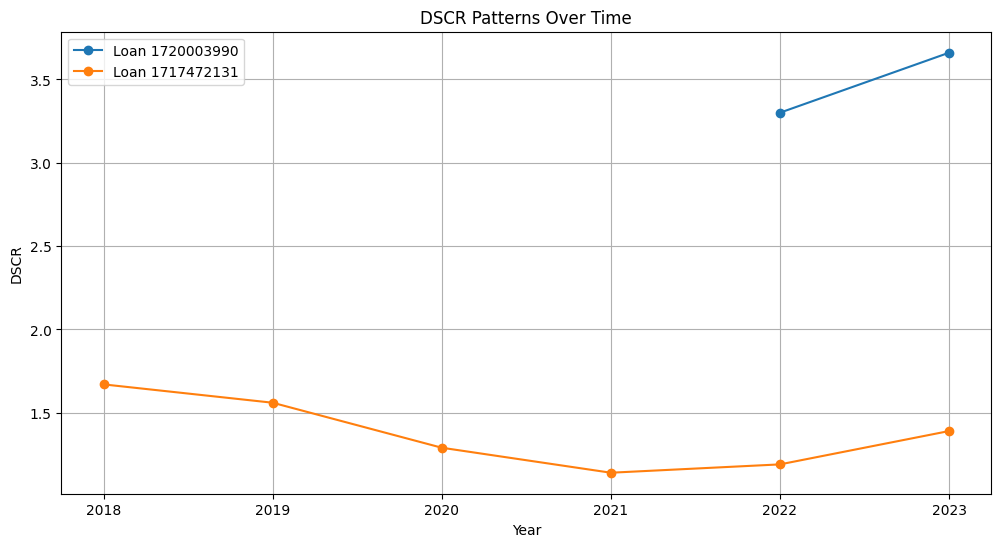

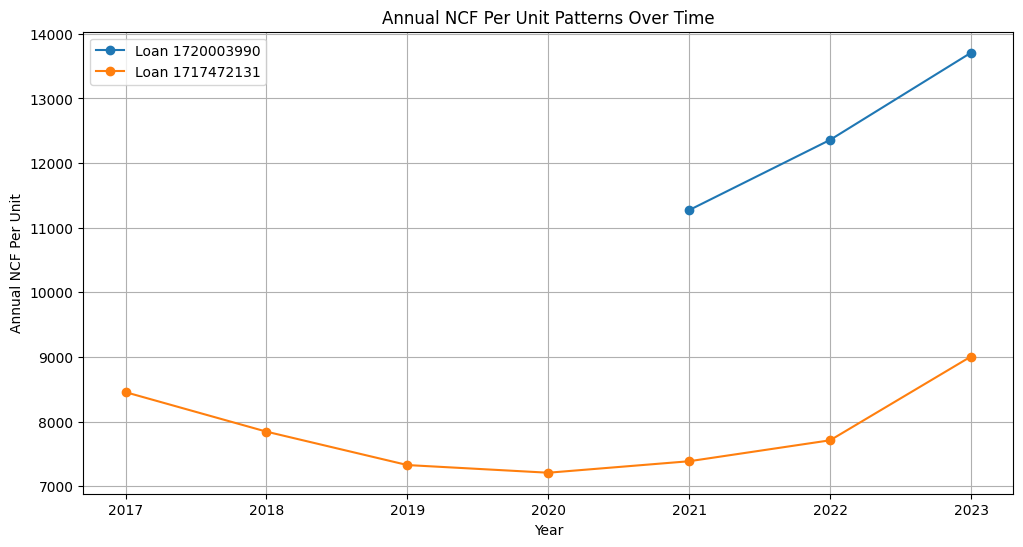

In [15]:
def plot_metric_patterns(df, metric_col, ylabel, loan_numbers=None):
    """Plot time series patterns for specified loans and metric"""
    loan_numbers = loan_numbers or df['Loan Number'].unique()[:5]
    
    plt.figure(figsize=(12, 6))
    for loan in loan_numbers:
        loan_data = df[df['Loan Number'] == loan].sort_values('Year')
        plt.plot(loan_data['Year'], loan_data[metric_col], marker='o', label=f'Loan {loan}')
    
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} Patterns Over Time')
    plt.legend()
    plt.grid(True)
    return plt

# Usage:
sample_loans = [annual_performance['Loan Number'].sample(1).iloc[0], 
                annual_performance['Loan Number'].sample(1).iloc[0]]

plot_metric_patterns(annual_performance, 'Year DSCR', 'DSCR', sample_loans)
plot_metric_patterns(annual_performance, 'Annual NCF Per Unit', 'Annual NCF Per Unit', sample_loans)

## 4. Add the Zip Code Level Median Income from Cencus Data

In [16]:
df = annual_performance.copy()
# Load the census data and filter necessary columns
census = pd.read_pickle('census.pickle')
census = census[['median_income', 'Year', 'ZIP']]

# Define main variable names
main_zip_name = 'Property Zip Code'
main_year_name = 'Year'

# Drop rows with NaN in 'median_income' in census data
census.dropna(subset=['median_income'], inplace=True)

# Rename columns in census to match the main variable names
census.rename(columns={'ZIP': main_zip_name, 'Year': main_year_name}, inplace=True)

# Ensure ZIP codes are strings in both dataframes for merging
df[main_zip_name] = df[main_zip_name].astype(str)
census[main_zip_name] = census[main_zip_name].astype(str)

# Drop rows with NaN in 'origination_date' in df data
#df = df.dropna(subset=['origination_date'])

# Extract the year from 'origination_date' in df and rename the new column to match main_year_name
df[main_year_name ] = df[main_year_name ].astype(int)
census[main_year_name] = census[main_year_name].astype(int)

# Sort both dataframes by the necessary columns for merge_asof
df = df.sort_values(by=[main_year_name, main_zip_name]).reset_index(drop=True)
census = census.sort_values(by=[main_year_name, main_zip_name]).reset_index(drop=True)

# Perform merge_asof based on 'origination_year' and 'zip' column names
df_census = pd.merge_asof(
    df,
    census,
    left_on=main_year_name ,
    right_on=main_year_name,
    by=main_zip_name,
    direction='nearest',
    suffixes=('', '_census')
)
df_census.sort_values(by=['Loan Number','Year'],inplace=True)
df_census['ln_median_income'] = np.log(df_census['median_income'])
annual_performance_census = df_census.copy()

In [17]:
#annual_performance = df_census
annual_performance_census.to_pickle('annual_performance_uw_ncf_t0.pickle')

In [18]:
df = mortgage_activity.copy()
# Load the census data and filter necessary columns
census = pd.read_pickle('census.pickle')
census = census[['median_income', 'Year', 'ZIP']]

# Define main variable names
main_zip_name = 'Property Zip Code'
main_year_name = 'Note Year'

# Drop rows with NaN in 'median_income' in census data
census.dropna(subset=['median_income'], inplace=True)

# Rename columns in census to match the main variable names
census.rename(columns={'ZIP': main_zip_name, 'Year': main_year_name}, inplace=True)

# Ensure ZIP codes are strings in both dataframes for merging
df[main_zip_name] = df[main_zip_name].astype(str)
census[main_zip_name] = census[main_zip_name].astype(str)

# Drop rows with NaN in 'origination_date' in df data
#df = df.dropna(subset=['origination_date'])

# Extract the year from 'origination_date' in df and rename the new column to match main_year_name
df[main_year_name ] = df[main_year_name ].astype(int)
census[main_year_name] = census[main_year_name].astype(int)

# Sort both dataframes by the necessary columns for merge_asof
df = df.sort_values(by=[main_year_name, main_zip_name]).reset_index(drop=True)
census = census.sort_values(by=[main_year_name, main_zip_name]).reset_index(drop=True)

# Perform merge_asof based on 'origination_year' and 'zip' column names
df_census = pd.merge_asof(
    df,
    census,
    left_on=main_year_name ,
    right_on=main_year_name,
    by=main_zip_name,
    direction='nearest',
    suffixes=('', '_census')
)
df_census.sort_values(by=['Loan Number',main_year_name],inplace=True)
df_census['ln_median_income'] = np.log(df_census['median_income'])
mortgage_activity_census = df_census.copy()

In [19]:
#mortgage_activity = df_census
mortgage_activity_census.to_pickle('mortgage_activity_uw_ncf_t0.pickle')

In [20]:
annual_performance_census[['Loan Number','Year','Real Annual NCF Per Unit','Real Underwritten Annual NCF Per Unit','Note Year']]

,Loan Number,Year,Real Annual NCF Per Unit,Real Underwritten Annual NCF Per Unit,Note Year
3156,1674029886,2007,5566.4614,3026.3862,2000
13098,1674029886,2008,5540.8089,3026.3862,2000
1697,1674042640,2007,12113.5920,11907.0394,2000
11283,1674042640,2008,11647.5493,11907.0394,2000
4670,1674044964,2007,2257.6143,4241.6072,2000
...,...,...,...,...,...
247512,8300008174,2021,5747.9715,5069.4611,2020
270911,8300008174,2022,5800.3116,5069.4611,2020
247856,8300008176,2021,8623.2985,8623.2985,2021
271230,8300008176,2022,7371.9866,8623.2985,2021


In [21]:
annual_performance_census[['Loan Number','Year','Real Annual NCF Per Unit','Real Underwritten Annual NCF Per Unit','Note Year']]

,Loan Number,Year,Real Annual NCF Per Unit,Real Underwritten Annual NCF Per Unit,Note Year
3156,1674029886,2007,5566.4614,3026.3862,2000
13098,1674029886,2008,5540.8089,3026.3862,2000
1697,1674042640,2007,12113.5920,11907.0394,2000
11283,1674042640,2008,11647.5493,11907.0394,2000
4670,1674044964,2007,2257.6143,4241.6072,2000
...,...,...,...,...,...
247512,8300008174,2021,5747.9715,5069.4611,2020
270911,8300008174,2022,5800.3116,5069.4611,2020
247856,8300008176,2021,8623.2985,8623.2985,2021
271230,8300008176,2022,7371.9866,8623.2985,2021
